# Quality Control

## Introduction
AnnData 개체로 제공되는 사람 피부 세포 데이터를 가지고 QC를 진행합니다. 데이터를 읽어오고 ERCC(spike-in)을 찾습니다.


In [1]:
import scanpy as sc 
import pandas as pd 
# qc metric 시각화하기 위해 matplotlib를 import합니다
import matplotlib.pyplot as plt 

%matplotlib inline 

adata = sc.read('./data/TS_Skin.h5ad')

print(adata)

AnnData object with n_obs × n_vars = 9424 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'


In [2]:
# Genes that have spike-ins start with ERCC
is_spike_in = {}
number_of_spike_ins = 0

for g in adata.var_names:
    if 'ERCC' in g:
        is_spike_in[g] = True  # record that we found a spike-in
        number_of_spike_ins += 1  # bump the counter
    else:
        is_spike_in[g] = False  # record that this was not a spike-in

adata.var['ERCC'] = pd.Series(
    is_spike_in)  # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many spike ins: ', number_of_spike_ins)

# adata.var['ERCC'] = adata.var_names.str.startswith('ERCC')

found this many spike ins:  10


In [3]:
# Genes that have spike-ins start with ERCC
is_mito_in = {}
number_of_mito = 0

for g in adata.var_names:
    if 'MT' in g:
        is_mito_in[g] = True  # record that we found a spike-in
        number_of_mito += 1  # bump the counter
    else:
        is_mito_in[g] = False  # record that this was not a spike-in

adata.var['MT'] = pd.Series(
    is_spike_in)  # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many mito: ', number_of_mito)

# adata.var['mito'] = adata.var_names.str.startswith('MT-')

found this many mito:  765


가장 많이 발현된 유전자들을 보고 가겠습니다.

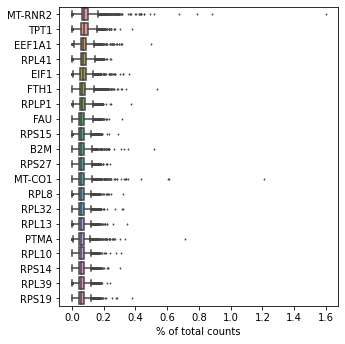

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20, )

## Computing QC metrics

QC metric을 계산한 다음 그에 맞게 세포와 유전자를 필터링합니다. pp.calculate_qc_metrics함수를 사용하면 많은 metric을 효율적으로 계산할 수 있습니다. compute_qc_metrics 함수는 두 개의 DataFrame을 반환합니다: 하나는 세포에 대한 quality control metric을 포함하고 다른 하나는 유전자에 대한 metric입니다. 

In [5]:
# (cell_qc_dataframe, gene_qc_dataframe) tuple을 반환
# 제어하려는 변수를 ERCC로 설정
                                
qc = sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'])
                                                        
cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

print('세포에 대한 quality control metric:')
print(cell_qc_dataframe.head(3))

print('\n유전자에 대한 quality control metric:')
print(gene_qc_dataframe.head(3))

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


세포에 대한 quality control metric:
                                        n_genes_by_counts  \
cell_id                                                     
AAACCCAAGAAGGTAG_TSP10_Skin_NA_10X_1_1               1513   
AAACCCAAGTGACCTT_TSP10_Skin_NA_10X_1_1               1474   
AAACCCAAGTTATGGA_TSP10_Skin_NA_10X_1_1                883   

                                        log1p_n_genes_by_counts  total_counts  \
cell_id                                                                         
AAACCCAAGAAGGTAG_TSP10_Skin_NA_10X_1_1                 7.322510   3339.728516   
AAACCCAAGTGACCTT_TSP10_Skin_NA_10X_1_1                 7.296413   3907.855713   
AAACCCAAGTTATGGA_TSP10_Skin_NA_10X_1_1                 6.784457   3244.276123   

                                        log1p_total_counts  \
cell_id                                                      
AAACCCAAGAAGGTAG_TSP10_Skin_NA_10X_1_1            8.113944   
AAACCCAAGTGACCTT_TSP10_Skin_NA_10X_1_1            8.271000   
AAACCCAAG

## QC for cells

### Library size

Read가 적은 세포는 손상되었거나 세포 캡처에 실패했을 가능성이 높으므로 제거를 하는 게 좋습니다.

(0.0, 10000.0)

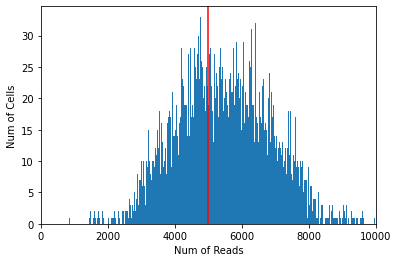

In [6]:
plt.hist(cell_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Num of Reads')
plt.ylabel('Num of Cells')
# 5000개 미만의 read가 있는 세포들을 보기 위해 선을 긋습니다 (빨간색 선)
plt.axvline(5000, color='red')
# x axis를 0~10000으로 합니다
plt.xlim(0,1e4)

Read의 수가 5,000개 미만인 세포가 제거되지 않았습니다. 

### Detected Genes

이제 read가 transcriptome 전체에 잘 분산됬는지 확인해야합니다. 이것을 위해 각 샘플에서 감지한 고유한 유전자의 총 수를 계산합니다.

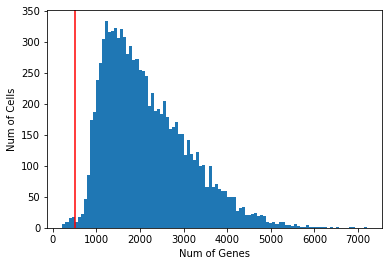

In [7]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('Num of Genes')
plt.ylabel('Num of Cells')
plt.axvline(500, color='red')

### Spike-ins (ERCC)

세포 품질의 또 다른 측정 방법은 spike-in RNA와 endogenous RNA 간의 비율을 보는 것입니다. 높은 비율의 spike-in RNA가 있는 세포는 RNA의 양이 적은 편인데, 이는 세포가 죽거나 스트레스를 받아 RNA degration이 일어날 수 있기 때문입니다.

한번 ERCC의 비율이 10%인 지점에 선을 그어보겠습니다. Threshold를 설정할 때는 항상 상황에 따른 판단을 잘 해야 합니다.

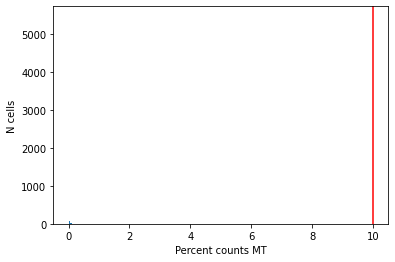

In [8]:
plt.hist(cell_qc_dataframe['pct_counts_MT'], bins=1000)
plt.xlabel('Percent counts MT')
plt.ylabel('N cells')

plt.axvline(10, color='red')

결과를 보면 세포의 spike-in 비율이 전부 10% 이하라는 것을 볼 수 있습니다. 

## Cell Filtering

이제 결과를 기반으로 cell filtering을 할 차례입니다. 

In [9]:
# 500개 미만의 유전자가 검출된 세포를 필터링합니다
sc.pp.filter_cells(adata, min_genes = 500)
print('\n\nAfter: \n', adata)



After: 
 AnnData object with n_obs × n_vars = 9378 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ERCC', 'MT'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'


In [10]:
# 5000개 미만의 read를 가진 세포를 제거합니다. 
sc.pp.filter_cells(adata, min_counts = 5000)
print("\n\nAfter: ", adata)



After:  AnnData object with n_obs × n_vars = 5741 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'n_counts'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ERCC', 'MT'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'


## QC for genes

발현 수준이 "detectable" 하다고 간주되는 유전자만 남기는 것이 좋습니다. 2개 이상의 세포에 해당 유전자로부터 5개 이상의 read가 포함된 경우 "detectable" 하다고 할 수 있습니다. 특정 유전자들은 퀄리티가 낮은 세포에서만 검출될 수도 있기 때문에 세포 QC를 진행한 후에 유전자 QC를 진행해야 합니다. 

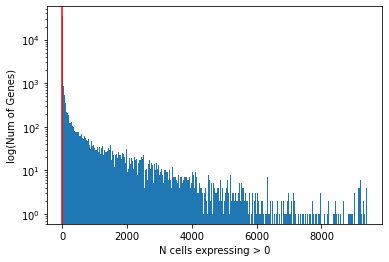

In [11]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(Num of Genes)')
# 최소 2개의 세포가 read를 포함 
plt.axvline(2, color='red')
# y축 스케일을 log로 설정
plt.yscale('log') 

* Tip: 실제로 코딩을 할 때는 각 그래프 전에 "a = plt.figure("graph name")"으로 그래프 이름을 설정해 주고 마지막 그래프 이후에 "plt.show()"를 적으면 모든 그래프를 동시에 볼 수 있습니다. 

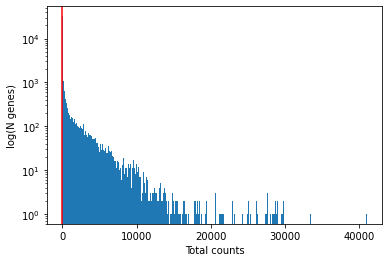

In [12]:
plt.hist(gene_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('log(N genes)') 
plt.yscale('log') 
# 해당 유전자로부터 10개 이상의 read가 포함된 경우
plt.axvline(10, color='red')

## Gene Filtering

이제 결과를 기반으로 gene filtering을 할 차례입니다.

In [13]:
# 최소 2개의 세포에 read가 포함되는 경우
sc.pp.filter_genes(adata, min_cells = 2)
print('\n\nAfter filtering num of cells containing reads: \n', adata)
# 10개 이상의 read가 포함된 경우
sc.pp.filter_genes(adata, min_counts = 10)
print('\n\nAfter filtering number of reads from the gene: \n', adata)



After filtering num of cells containing reads: 
 AnnData object with n_obs × n_vars = 5741 × 33642
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'n_counts'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ERCC', 'MT', 'n_cells'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'


After filtering number of reads from the gene: 
 AnnData object with n_obs × n_va

위 결과를 통해 필터링 된 유전자는 없다는 것을 알 수 있습니다. 이제 QC가 진행된 데이터 세트를 저장합니다.

In [14]:
adata.write('./data/TS_Skin_qc.h5ad')